In [1]:
import einops
import torch

from einops.layers.torch import EinMix

from utils.components import *
from utils.config import *
from utils.einmask import EinMask

from utils.masking import *

In [2]:
import matplotlib.pyplot as plt

In [3]:
world = WorldConfig(field_sizes={"v": 6, "t": 36, "h": 64, "w": 120}, patch_sizes={'vv': 2, 'tt': 6, 'hh': 4, 'ww': 4}, batch_size=16)

In [5]:
network = NetworkConfig(dim=512, num_latents=32, num_layers=12, num_tails=4, use_checkpoint=False, dim_in=256)

In [6]:
cpe = ContinuousPositionalEmbedding(
    network.dim_coords, wavelengths=[(1, 16), (1, 16), (1, 64), (1, 64)], model_dim= network.dim_in
)

In [7]:
pos = torch.arange(world.num_tokens)
coords = torch.stack(torch.unravel_index(pos, world.token_shape), dim=-1)

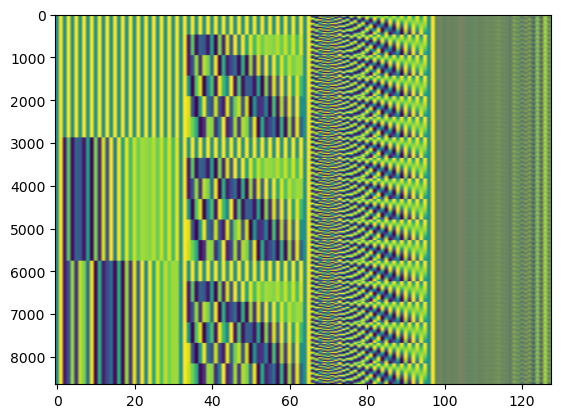

In [15]:
plt.imshow(cpe(coords) , aspect='auto')

In [5]:
test_in = EinMix(pattern=f"{world.field_pattern} -> b {world.flat_token_pattern} d", 
              weight_shape=f'v d {world.patch_pattern}', 
              bias_shape=f'{world.flat_token_pattern} d',
              **world.patch_sizes, **world.token_sizes, d = network.dim
              )

test_out = EinMix(
            pattern=f"b {world.flat_token_pattern} d -> {world.field_pattern} e", 
            weight_shape=f'e v {world.patch_pattern} d', 
            bias_shape=f'e v {world.patch_pattern}',
            **world.patch_sizes, **world.token_sizes, d = network.dim, e = network.num_tails
            )

In [6]:
a = torch.randn((world.batch_size, world.field_sizes['v'], world.field_sizes['t'], world.field_sizes['h'], world.field_sizes['w']))
b = test_in(a)
c = test_out(b)

print(a.shape)
print(b.shape)
print(c.shape)

print(test_in.weight.shape)
print(test_in.bias.shape)

torch.Size([16, 6, 36, 64, 120])
torch.Size([16, 8640, 256])
torch.Size([16, 6, 36, 64, 120, 4])
torch.Size([3, 256, 2, 6, 4, 4])
torch.Size([1, 3, 6, 16, 30, 256])


Text(0, 0.5, 'masking rate')

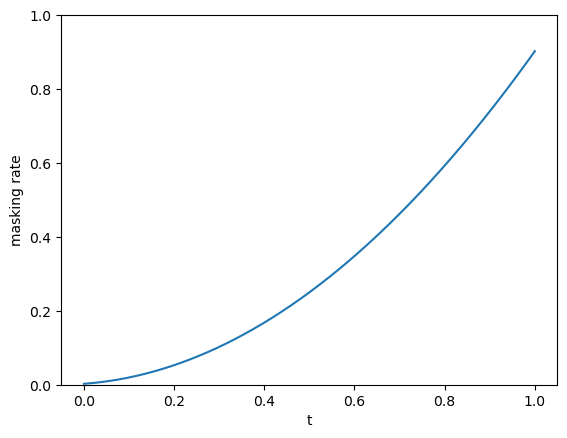

In [29]:
objective = ObjectiveConfig(c1=0.5, c0=1)
u = torch.linspace(0,1,1000)
km = KumaraswamySchedule(objective=objective)
plt.plot(u,km(u)[0])
plt.ylim(0,1)
plt.xlabel('t')
plt.ylabel('masking rate')

In [43]:
model = EinMask(network, world).to("cuda")
a = torch.randn((world.batch_size, world.field_sizes['v'], world.field_sizes['t'], world.field_sizes['h'], world.field_sizes['w']))

In [44]:
with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16):
    d = model(a.to("cuda"), src.to("cuda"))